# Download

Mouse spermatogenesis cells from Ernst et al (https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-6946/).

Human spermatogenesis cells from Shami et al (GSE142585).

Macaque spermatogenesis cells from Shami et al (GSE142585).

# Gene lists
We retrieved one-to-one orthologues (human vs mouse, human vs macaque) respectively from Ensembl Biomart.

The used gene lists are available as "orthologues_human_mouse.txt" and "orthologues_human_macaque.txt". 

# Preprocess
We use the R code "preprocess_spermatogenesis.R" for part of preprocessing. Run preprocess_spermatogenesis.R before using this code.

In [1]:
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
import anndata2ri
import numpy as np
import pandas as pd
import anndata
import os

In [2]:
# preprocess for Portal integration
ro.r['library']("Seurat")

ro.r('''load("./data_spermatogenesis/obj_human_sharedgenes.RData")''') # obj_human
ro.r('''load("./data_spermatogenesis/obj_mouse_sharedgenes.RData")''') # obj_mouse
ro.r('''load("./data_spermatogenesis/obj_macaque_sharedgenes.RData")''') # obj_macaque


ro.r('''cnts_human <- obj_human[["RNA"]]@counts''')
counts_human = np.array(ro.r("as.matrix(cnts_human)"))
genes_human = list(ro.r("as.vector(rownames(cnts_human))"))
cells_human = list(ro.r("as.vector(colnames(cnts_human))"))


ro.r('''cnts_mouse <- obj_mouse[["RNA"]]@counts''')
ro.r("cell_type <- as.vector(obj_mouse$cell_type)")
counts_mouse = np.array(ro.r('''as.matrix(cnts_mouse)'''))
genes_mouse = list(ro.r("as.vector(rownames(cnts_mouse))"))
cells_mouse = list(ro.r("as.vector(colnames(cnts_mouse))"))
cell_type_mouse = list(ro.r("as.vector(cell_type)"))


ro.r('''cnts_macaque <- obj_macaque[["RNA"]]@counts''')
counts_macaque = np.array(ro.r('''as.matrix(cnts_macaque)'''))
genes_macaque = list(ro.r("as.vector(rownames(cnts_macaque))"))
cells_macaque = list(ro.r("as.vector(colnames(cnts_macaque))"))


adata_human = anndata.AnnData(counts_human.T)
adata_human.obs.index = cells_human
adata_human.var.index = genes_human
adata_mouse = anndata.AnnData(counts_mouse.T)
adata_mouse.obs.index = cells_mouse
adata_mouse.var.index = genes_mouse
adata_macaque = anndata.AnnData(counts_macaque.T)
adata_macaque.obs.index = cells_macaque
adata_macaque.var.index = genes_macaque

ro.r('''anno_human <- read.table("./Raw_data_Shami/GSE142585_MergedHumanTestis4_PerCellAttributes.txt")''')
ro.r('''write.csv(anno_human, file="./Raw_data_Shami/create_GSE142585_MergedHumanTestis4_PerCellAttributes.csv")''')
cell_type_human_ref = pd.read_csv("./Raw_data_Shami/create_GSE142585_MergedHumanTestis4_PerCellAttributes.csv", index_col=0)
cell_type_human_ref = cell_type_human_ref.loc[list(adata_human.obs.index)]

ro.r('''anno_macaque <- read.table("./Raw_data_Shami/GSE142585_MergedMonkeyTestis5_PerCellAttributes.txt")''')
ro.r('''write.csv(anno_macaque, file="./Raw_data_Shami/create_GSE142585_MergedMonkeyTestis5_PerCellAttributes.csv")''')
cell_type_macaque_ref = pd.read_csv("./Raw_data_Shami/create_GSE142585_MergedMonkeyTestis5_PerCellAttributes.csv", index_col=0)
cell_type_macaque_ref = cell_type_macaque_ref.loc[list(adata_macaque.obs.index)]

cell_type_mouse = pd.read_csv("./data_spermatogenesis/mouseP30-anno.csv", index_col="barcode")

adata_human.obs["human_cell_type"] = ""
adata_human.obs["human_cell_type_ref"] = cell_type_human_ref["CellType"].values
adata_human.obs["method"] = "human"
adata_mouse.obs["mouse_cell_type"] = cell_type_mouse["cell_type_new"].values
adata_mouse.obs["method"] = "mouse"
adata_macaque.obs["macaque_cell_type"] = ""
adata_macaque.obs["macaque_cell_type_ref"] = cell_type_macaque_ref["CellType"].values
adata_macaque.obs["method"] = "macaque"

data_path = "data_spermatogenesis/"
if not os.path.exists(data_path):
    os.makedirs(data_path)

adata_human.obs.index = adata_human.obs.index + "_human"
adata_mouse.obs.index = adata_mouse.obs.index + "_mouse"
adata_macaque.obs.index = adata_macaque.obs.index + "_macaque"

meta = pd.concat([adata_human.obs, adata_mouse.obs, adata_macaque.obs], axis=0)
meta.to_pickle(os.path.join(data_path, "meta.pkl"))
meta.to_csv(os.path.join(data_path, "meta.csv"))

print(len(set(adata_human.var.index) & set(adata_mouse.var.index)))
print(len(set(adata_human.var.index) & set(adata_macaque.var.index)))
print(len(set(adata_mouse.var.index) & set(adata_macaque.var.index)))

adata_human.write(filename=os.path.join(data_path, "adata_human.h5ad"))
adata_mouse.write(filename=os.path.join(data_path, "adata_mouse.h5ad"))
adata_macaque.write(filename=os.path.join(data_path, "adata_macaque.h5ad"))

R[write to console]: 
Seurat v4 will be going to CRAN in the near future;
 for more details, please visit https://satijalab.org/seurat/v4_changes


... storing 'human_cell_type' as categorical
... storing 'human_cell_type_ref' as categorical
... storing 'method' as categorical


11922
11922
11922


... storing 'mouse_cell_type' as categorical
... storing 'method' as categorical
... storing 'macaque_cell_type' as categorical
... storing 'macaque_cell_type_ref' as categorical
... storing 'method' as categorical


In [3]:
# preprocess for downstream analysis
ro.r['library']("Seurat")

ro.r('''load("./data_spermatogenesis/obj_human.RData")''') # obj_human
ro.r('''load("./data_spermatogenesis/obj_mouse.RData")''') # obj_mouse
ro.r('''load("./data_spermatogenesis/obj_macaque.RData")''') # obj_macaque


ro.r('''cnts_human <- obj_human[["RNA"]]@counts''')
counts_human = np.array(ro.r("as.matrix(cnts_human)"))
genes_human = list(ro.r("as.vector(rownames(cnts_human))"))
cells_human = list(ro.r("as.vector(colnames(cnts_human))"))


ro.r('''cnts_mouse <- obj_mouse[["RNA"]]@counts''')
counts_mouse = np.array(ro.r('''as.matrix(cnts_mouse)'''))
genes_mouse = list(ro.r("as.vector(rownames(cnts_mouse))"))
cells_mouse = list(ro.r("as.vector(colnames(cnts_mouse))"))


ro.r('''cnts_macaque <- obj_macaque[["RNA"]]@counts''')
counts_macaque = np.array(ro.r('''as.matrix(cnts_macaque)'''))
genes_macaque = list(ro.r("as.vector(rownames(cnts_macaque))"))
cells_macaque = list(ro.r("as.vector(colnames(cnts_macaque))"))


adata_human = anndata.AnnData(counts_human.T)
adata_human.obs.index = cells_human
adata_human.var.index = genes_human
adata_mouse = anndata.AnnData(counts_mouse.T)
adata_mouse.obs.index = cells_mouse
adata_mouse.var.index = genes_mouse
adata_macaque = anndata.AnnData(counts_macaque.T)
adata_macaque.obs.index = cells_macaque
adata_macaque.var.index = genes_macaque

adata_human.obs.index = adata_human.obs.index + "_human"
adata_mouse.obs.index = adata_mouse.obs.index + "_mouse"
adata_macaque.obs.index = adata_macaque.obs.index + "_macaque"

adata_human.write(filename=os.path.join(data_path, "adata_human_raw.h5ad"))
adata_mouse.write(filename=os.path.join(data_path, "adata_mouse_raw.h5ad"))
adata_macaque.write(filename=os.path.join(data_path, "adata_macaque_raw.h5ad"))

# Integration using Portal

In [4]:
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn import preprocessing
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap

In [5]:
adata_human = sc.read_h5ad(os.path.join(data_path, "adata_human.h5ad"))
adata_macaque = sc.read_h5ad(os.path.join(data_path, "adata_macaque.h5ad"))
adata_mouse = sc.read_h5ad(os.path.join(data_path, "adata_mouse.h5ad"))

meta = pd.read_pickle(os.path.join(data_path, "meta.pkl"))

In [6]:
import portal

# Specify the GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Create a folder for saving results
result_path = "result"
if not os.path.exists(result_path):
    os.makedirs(result_path)

In [7]:
lowdim_list = portal.utils.preprocess_datasets([adata_mouse, adata_macaque, adata_human], hvg_num=3000)
integrated_data = portal.utils.integrate_datasets(lowdim_list, lambda_cos=10.0, training_steps=2000)

Finding highly variable genes...
Normalizing and scaling...


/home/jzhaoaz/.local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Dimensionality reduction via PCA...
Incrementally integrating 3 datasets...
Integrating the 2-th dataset to the 1-st dataset...
Begining time:  Thu Mar 17 17:21:20 2022
step 0, loss_D=9.207967, loss_GAN=3.202281, loss_AE=171.469498, loss_cos=19.920729, loss_LA=118.995583
step 200, loss_D=2.695100, loss_GAN=7.225171, loss_AE=7.956108, loss_cos=5.797306, loss_LA=1.782713
step 400, loss_D=2.314644, loss_GAN=4.720937, loss_AE=5.682328, loss_cos=6.272050, loss_LA=1.226438
step 600, loss_D=2.458613, loss_GAN=4.728247, loss_AE=4.558582, loss_cos=6.706512, loss_LA=1.222764
step 800, loss_D=1.999094, loss_GAN=3.741357, loss_AE=3.722260, loss_cos=6.514924, loss_LA=0.720958
step 1000, loss_D=1.931379, loss_GAN=4.148803, loss_AE=3.621000, loss_cos=6.867559, loss_LA=0.740857
step 1200, loss_D=1.584124, loss_GAN=3.788886, loss_AE=3.253426, loss_cos=6.010096, loss_LA=0.544792
step 1400, loss_D=1.786813, loss_GAN=3.654599, loss_AE=3.048253, loss_cos=6.352377, loss_LA=0.574668
step 1600, loss_D=1.92013

UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation',
     min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1,
     verbose=True)
Construct fuzzy simplicial set
Thu Mar 17 17:22:52 2022 Finding Nearest Neighbors
Thu Mar 17 17:22:52 2022 Building RP forest with 10 trees
Thu Mar 17 17:22:53 2022 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
Thu Mar 17 17:23:01 2022 Finished Nearest Neighbor Search


/home/jzhaoaz/.conda/envs/scUNIT/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Thu Mar 17 17:23:03 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


... storing 'human_cell_type' as categorical
... storing 'human_cell_type_ref' as categorical
... storing 'method' as categorical
... storing 'mouse_cell_type' as categorical
... storing 'macaque_cell_type' as categorical
... storing 'macaque_cell_type_ref' as categorical


Thu Mar 17 17:23:34 2022 Finished embedding


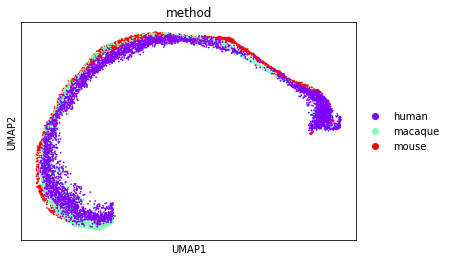

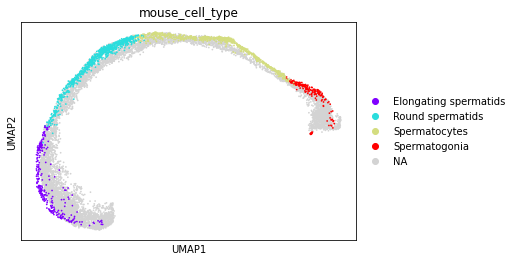

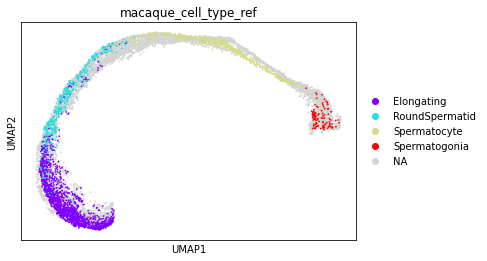

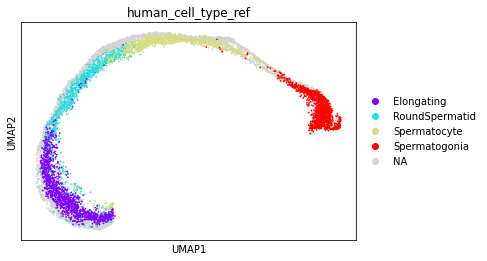

In [8]:
# The integration result can be visualized by portal.utils.plot_UMAP
portal.utils.plot_UMAP(integrated_data, 
                       meta.loc[list(adata_mouse.obs.index) + list(adata_macaque.obs.index) + list(adata_human.obs.index)], 
                       colors=["method", "mouse_cell_type", "macaque_cell_type_ref", "human_cell_type_ref"], 
                       save=True, result_path=result_path)

# Analysis

In [9]:
from sklearn import preprocessing
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist
import umap
import anndata
import random

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.2 anndata==0.7.6 umap==0.4.6 numpy==1.19.2 scipy==1.6.2 pandas==1.1.5 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.7.0


In [10]:
adata_human = sc.read_h5ad(os.path.join(data_path, "adata_human.h5ad"))
adata_macaque = sc.read_h5ad(os.path.join(data_path, "adata_macaque.h5ad"))
adata_mouse = sc.read_h5ad(os.path.join(data_path, "adata_mouse.h5ad"))

# Order
adata_A = adata_mouse.copy()
adata_B = adata_macaque.copy()
adata_C = adata_human.copy()

reducer = umap.UMAP(n_neighbors=30,
                    n_components=2,
                    metric="correlation",
                    n_epochs=None,
                    learning_rate=1.0,
                    min_dist=0.3,
                    spread=1.0,
                    set_op_mix_ratio=1.0,
                    local_connectivity=1,
                    repulsion_strength=1,
                    negative_sample_rate=5,
                    a=None,
                    b=None,
                    random_state=1234,
                    metric_kwds=None,
                    angular_rp_forest=False,
                    verbose=True)

embedding = reducer.fit_transform(integrated_data)

emb = integrated_data
meta = pd.read_pickle(os.path.join(data_path, "meta.pkl"))
meta = meta.loc[list(adata_A.obs.index) + list(adata_B.obs.index) + list(adata_C.obs.index)]

le = preprocessing.LabelEncoder()
le.fit(sorted(set(meta["method"])))
label = le.transform(meta["method"].values)

pal = [i for i in get_cmap('Set2').colors]
palhex = [mpl.colors.rgb2hex(color) for color in pal]

colours = ListedColormap([palhex[0], palhex[1], palhex[2]])

n_cells = embedding.shape[0]
size = 120000 / n_cells

UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation',
     min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1,
     verbose=True)
Construct fuzzy simplicial set
Thu Mar 17 17:23:37 2022 Finding Nearest Neighbors
Thu Mar 17 17:23:37 2022 Building RP forest with 10 trees
Thu Mar 17 17:23:37 2022 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
Thu Mar 17 17:23:40 2022 Finished Nearest Neighbor Search
Thu Mar 17 17:23:40 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Mar 17 17:24:11 2022 Finished embedding


In [11]:
# Clustering
emb = integrated_data

le = preprocessing.LabelEncoder()
le.fit(sorted(set(meta["method"])))
label = le.transform(meta["method"].values)

cellid = meta.index.astype(str)
lowdim = integrated_data

rpy2.robjects.numpy2ri.activate()
nr, nc = lowdim.shape
lowdim = ro.r.matrix(lowdim, nrow=nr, ncol=nc)
ro.r.assign("data", lowdim)
rpy2.robjects.numpy2ri.deactivate()

cellid = ro.StrVector(cellid)
ro.r.assign("cellid", cellid)

ro.r("set.seed(1234)")
ro.r['library']("Seurat")

ro.r("comb_normalized <- t(data)")
ro.r('''rownames(comb_normalized) <- paste("gene", 1:nrow(comb_normalized), sep = "")''')
ro.r("colnames(comb_normalized) <- as.vector(cellid)")
ro.r("comb_raw <- matrix(0, nrow = nrow(comb_normalized), ncol = ncol(comb_normalized))")
ro.r("rownames(comb_raw) <- rownames(comb_normalized)")
ro.r("colnames(comb_raw) <- colnames(comb_normalized)")
ro.r("comb <- CreateSeuratObject(comb_raw)")
ro.r('''portaldata <- Seurat::CreateDimReducObject(
            embeddings = t(comb_normalized),
            stdev = as.numeric(apply(comb_normalized, 2, stats::sd)),
            assay = "RNA",
            key = "portal")''')
ro.r('''comb[["portal"]] <- portaldata''')
ro.r('''comb <- FindNeighbors(comb, reduction = "portal", dims = 1:ncol(data), force.recalc = TRUE, verbose = FALSE)''')
ro.r('''comb <- FindClusters(comb, resolution=1.5, verbose = FALSE, random.seed=1234)''')
ro.r('''louvain <- as.vector(comb$seurat_clusters)''')

louvain = ro.r("louvain")
louvain = list(louvain)
meta["louvain"] = louvain
meta.to_pickle(os.path.join(result_path, "meta_louvain.pkl"))

n_cells = lowdim.shape[0]
if n_cells >= 15000:
    size = 120000 / n_cells
else:
    size = 8
    
# Clean louvain clusters
meta = pd.read_pickle(os.path.join(result_path, "meta_louvain.pkl"))
meta["louvain_v2"] = "0"
meta["louvain_v2"][(meta["louvain"].values.astype(str) == "16") |
                   (meta["louvain"].values.astype(str) == "18") |
                   (meta["louvain"].values.astype(str) == "7") |
                   (meta["louvain"].values.astype(str) == "19")] = "1"
meta_lou = meta

emb = emb[meta_lou["louvain_v2"].values.astype(str)!="1", :]
embedding = embedding[meta_lou["louvain_v2"].values.astype(str)!="1", :]
label = label[meta_lou["louvain_v2"].values.astype(str)!="1"]

meta = meta[meta_lou["louvain_v2"].values.astype(str)!="1"]
meta_lou = meta_lou[meta_lou["louvain_v2"].values.astype(str)!="1"]

R[write to console]: Warning:
R[write to console]:  Keys should be one or more alphanumeric characters followed by an underscore, setting key from portal to portal_

R[write to console]: Warning:
R[write to console]:  All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to portal_



In [12]:
meta_human = meta.loc[(meta["method"].values.astype(str) == "human"), :].copy()
meta_macaque = meta.loc[(meta["method"].values.astype(str) == "macaque"), :].copy()
meta_mouse = meta.loc[(meta["method"].values.astype(str) == "mouse"), :].copy()

cell_type_mouse = pd.read_csv("./data_spermatogenesis/mouseP30-anno.csv", index_col="barcode")
cell_type_mouse.index = cell_type_mouse.index + "_mouse"
cell_type_mouse = cell_type_mouse.loc[meta_mouse.index, :].copy()

cell_type_macaque_ref = pd.read_csv("./Raw_data_Shami/create_GSE142585_MergedMonkeyTestis5_PerCellAttributes.csv", index_col=0)
cell_type_macaque_ref.index = cell_type_macaque_ref.index + "_macaque"
cell_type_macaque_ref = cell_type_macaque_ref.loc[meta_macaque.index, :].copy()

cell_type_human_ref = pd.read_csv("./Raw_data_Shami/create_GSE142585_MergedHumanTestis4_PerCellAttributes.csv", index_col=0)
cell_type_human_ref.index = cell_type_human_ref.index + "_human"
cell_type_human_ref = cell_type_human_ref.loc[meta_human.index, :].copy()

meta_mouse["mouse_cell_type"] = cell_type_mouse.loc[meta_mouse.index]["cell_type_new"]
meta_macaque["macaque_cell_type_ref"] = cell_type_macaque_ref.loc[meta_macaque.index]["CellType"]
meta_human["human_cell_type_ref"] = cell_type_human_ref.loc[meta_human.index]["CellType"]

emb_mouse = emb[:len(meta_mouse)]
emb_macaque = emb[len(meta_mouse):len(meta_mouse)+len(meta_macaque)]
emb_human = emb[len(meta_mouse)+len(meta_macaque):]

embedding_mouse = embedding[:len(meta_mouse)]
embedding_macaque = embedding[len(meta_mouse):len(meta_mouse)+len(meta_macaque)]
embedding_human = embedding[len(meta_mouse)+len(meta_macaque):]

In [13]:
label_human_new = portal.utils.annotate_by_nn(vec_tar=emb_human, vec_ref=emb_mouse, label_ref=np.array(meta_mouse["mouse_cell_type"].values))
label_macaque_new = portal.utils.annotate_by_nn(vec_tar=emb_macaque, vec_ref=emb_mouse, label_ref=np.array(meta_mouse["mouse_cell_type"].values))

In [14]:
le_celltype = preprocessing.LabelEncoder()
le_celltype.fit(sorted(set(meta_mouse["mouse_cell_type"].values)))
label_celltype_mouse = le_celltype.transform(meta_mouse["mouse_cell_type"].values)
colours_celltype = "rainbow"

le2_celltype = preprocessing.LabelEncoder()
le2_celltype.fit(sorted(set(meta_macaque["macaque_cell_type_ref"].values)))
label2_celltype_macaque = le2_celltype.transform(meta_macaque["macaque_cell_type_ref"].values)
colours_celltype = "rainbow"

label_celltype_macaque = le2_celltype.transform(meta_macaque["macaque_cell_type_ref"].values)
label_celltype_human = le2_celltype.transform(meta_human["human_cell_type_ref"].values)

colours4 = ListedColormap(["tab:red","tab:blue","tab:orange","tab:green"])

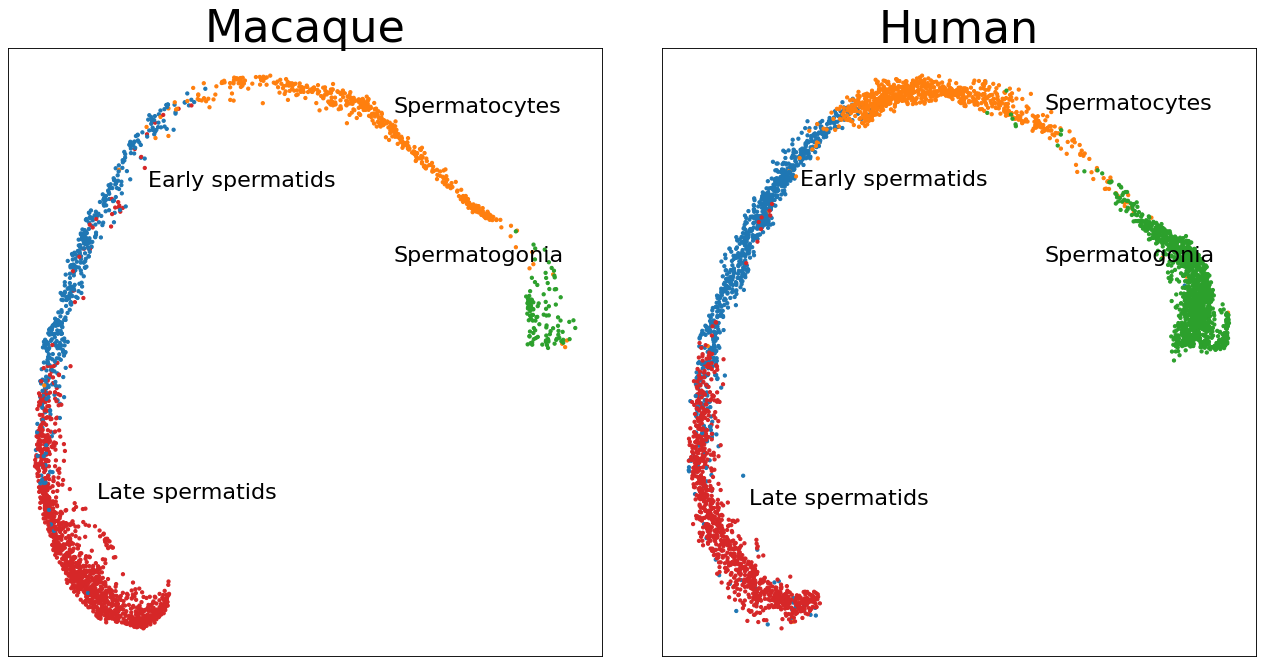

In [15]:
f = plt.figure(figsize=(20,10))

ax2 = f.add_subplot(1,2,1)
scatter = ax2.scatter(embedding_macaque[:, 0], embedding_macaque[:, 1], s=size, c=label_celltype_macaque, cmap=colours4, label=label_celltype_macaque)
ax2.set_title("Macaque", fontsize=40)
ax2.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax2.annotate("Late spermatids", rotation=0, fontsize=20, xy=(-3, -4))
ax2.annotate("Early spermatids", rotation=0, fontsize=20, xy=(-0.5, 6.5))
ax2.annotate("Spermatocytes", rotation=0, fontsize=20, xy=(11.5, 9.0))
ax2.annotate("Spermatogonia", rotation=0, fontsize=20, xy=(11.5, 4.0))

ax3 = f.add_subplot(1,2,2)
scatter = ax3.scatter(embedding_human[:, 0], embedding_human[:, 1], s=size, c=label_celltype_human, cmap=colours4, label=label_celltype_human)
ax3.set_title("Human", fontsize=40)
ax3.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax3.annotate("Late spermatids", rotation=0, fontsize=20, xy=(-3, -4))
ax3.annotate("Early spermatids", rotation=0, fontsize=20, xy=(-0.5, 6.5))
ax3.annotate("Spermatocytes", rotation=0, fontsize=20, xy=(11.5, 9.0))
ax3.annotate("Spermatogonia", rotation=0, fontsize=20, xy=(11.5, 4.0))


f.subplots_adjust(hspace=.1, wspace=.1)
plt.show()

In [16]:
le_celltype = preprocessing.LabelEncoder()
le_celltype.fit(sorted(set(meta_mouse["mouse_cell_type"].values)))
label_celltype_mouse = le_celltype.transform(meta_mouse["mouse_cell_type"].values)
colours_celltype = "rainbow"

label_celltype_macaque = le_celltype.transform(label_macaque_new)
label_celltype_human = le_celltype.transform(label_human_new)

colours4 = ListedColormap(["tab:red","tab:blue","tab:orange","tab:green"])

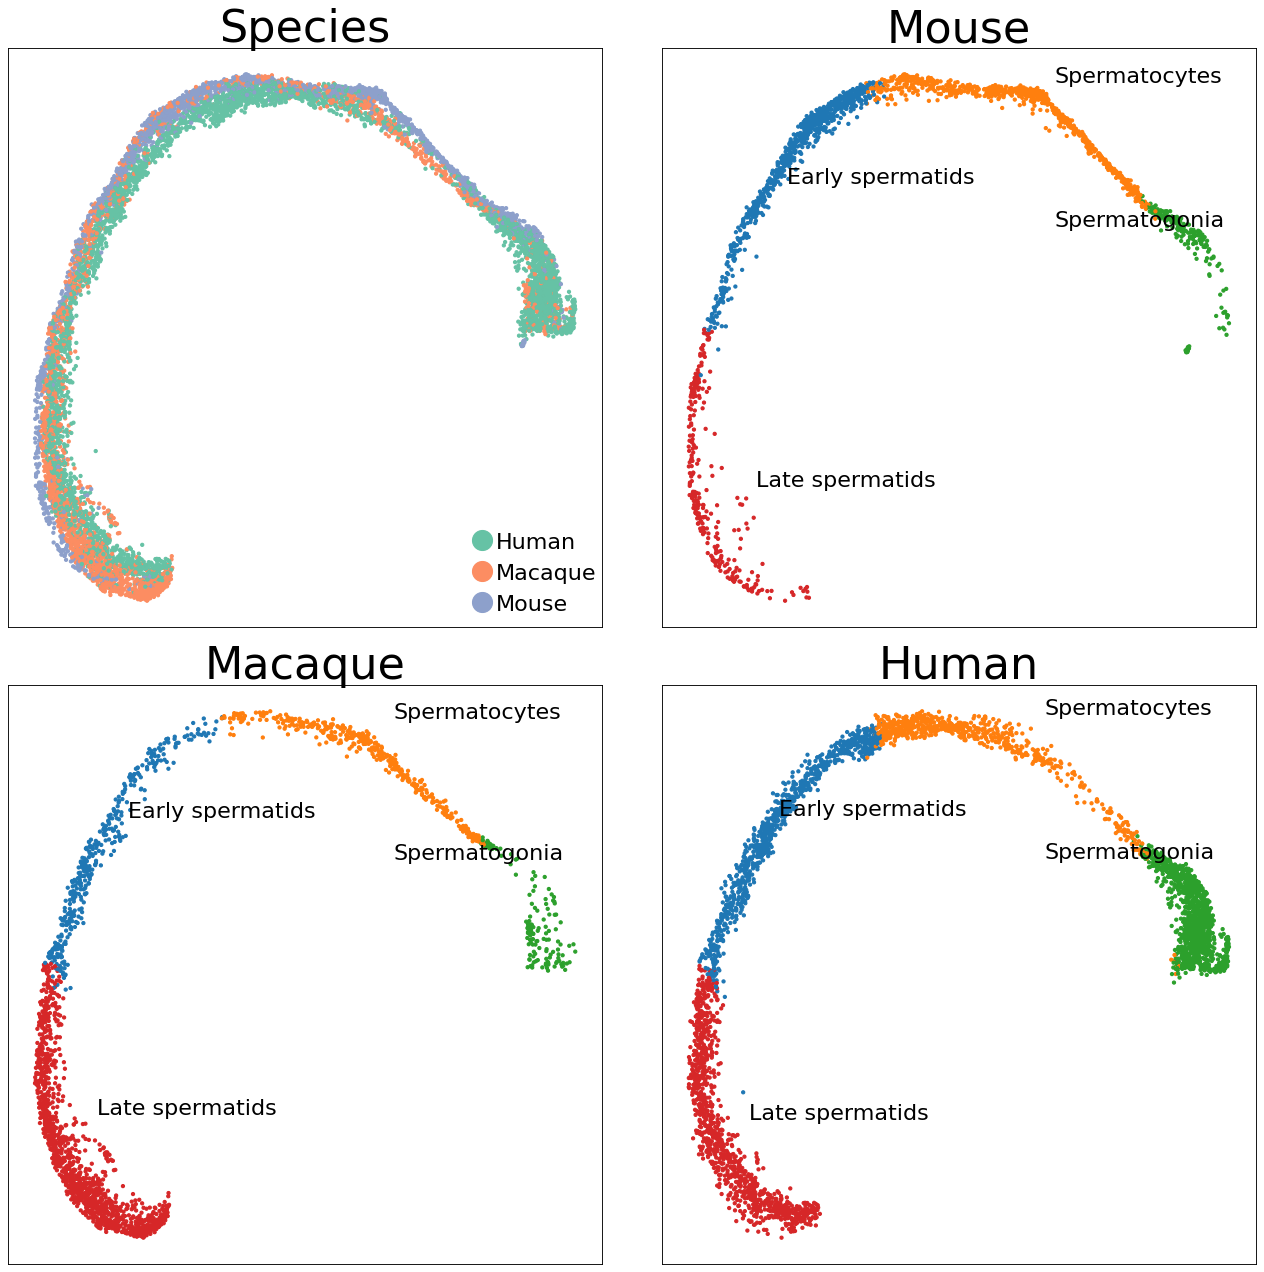

In [17]:
f = plt.figure(figsize=(20,20))

ax0 = f.add_subplot(2,2,1)
order = np.arange(len(embedding))
np.random.shuffle(order)
scatter0 = ax0.scatter(embedding[order, 0], embedding[order, 1], s=size, c=label[order], cmap=colours, label=meta["method"].values[order])
ax0.set_title("Species", fontsize=40)
ax0.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
l1 = f.legend(handles=scatter0.legend_elements(num=len(sorted(set(meta["method"].values))))[0], 
              labels=["Human", "Macaque", "Mouse"], #sorted(set(meta["method"].values)), 
              loc="upper left", 
              bbox_to_anchor=(0.46, 0.62), markerscale=3., title_fontsize=20, fontsize=20, frameon=False, ncol=1)

ax1 = f.add_subplot(2,2,2)
scatter = ax1.scatter(embedding_mouse[:, 0], embedding_mouse[:, 1], s=size, c=label_celltype_mouse, cmap=colours4, label=label_celltype_mouse)
ax1.set_title("Mouse", fontsize=40)
ax1.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax1.annotate("Late spermatids", rotation=0, fontsize=20, xy=(-3, -4))
ax1.annotate("Early spermatids", rotation=0, fontsize=20, xy=(-1.5, 6.5))
ax1.annotate("Spermatocytes", rotation=0, fontsize=20, xy=(11.5, 10.0))
ax1.annotate("Spermatogonia", rotation=0, fontsize=20, xy=(11.5, 5.0))

ax2 = f.add_subplot(2,2,3)
scatter = ax2.scatter(embedding_macaque[:, 0], embedding_macaque[:, 1], s=size, c=label_celltype_macaque, cmap=colours4, label=label_celltype_macaque)
ax2.set_title("Macaque", fontsize=40)
ax2.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax2.annotate("Late spermatids", rotation=0, fontsize=20, xy=(-3, -4))
ax2.annotate("Early spermatids", rotation=0, fontsize=20, xy=(-1.5, 6.5))
ax2.annotate("Spermatocytes", rotation=0, fontsize=20, xy=(11.5, 10.0))
ax2.annotate("Spermatogonia", rotation=0, fontsize=20, xy=(11.5, 5.0))

ax3 = f.add_subplot(2,2,4)
scatter = ax3.scatter(embedding_human[:, 0], embedding_human[:, 1], s=size, c=label_celltype_human, cmap=colours4, label=label_celltype_human)
ax3.set_title("Human", fontsize=40)
ax3.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax3.annotate("Late spermatids", rotation=0, fontsize=20, xy=(-3, -4))
ax3.annotate("Early spermatids", rotation=0, fontsize=20, xy=(-1.5, 6.5))
ax3.annotate("Spermatocytes", rotation=0, fontsize=20, xy=(11.5, 10.0))
ax3.annotate("Spermatogonia", rotation=0, fontsize=20, xy=(11.5, 5.0))


f.subplots_adjust(hspace=.1, wspace=.1)
plt.show()

In [18]:
meta_human["transfered_label"] = label_human_new
meta_macaque["transfered_label"] = label_macaque_new

In [19]:
# Joint clustering

import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
import anndata2ri

cellid = meta.index.astype(str)

rpy2.robjects.numpy2ri.activate()
nr, nc = emb.shape
lowdim = ro.r.matrix(emb, nrow=nr, ncol=nc)
ro.r.assign("data", lowdim)
rpy2.robjects.numpy2ri.deactivate()

cellid = ro.StrVector(cellid)
ro.r.assign("cellid", cellid)

ro.r("set.seed(1234)")
ro.r['library']("Seurat")

ro.r("comb_normalized <- t(data)")
ro.r('''rownames(comb_normalized) <- paste("gene", 1:nrow(comb_normalized), sep = "")''')
ro.r("colnames(comb_normalized) <- as.vector(cellid)")
ro.r("comb_raw <- matrix(0, nrow = nrow(comb_normalized), ncol = ncol(comb_normalized))")
ro.r("rownames(comb_raw) <- rownames(comb_normalized)")
ro.r("colnames(comb_raw) <- colnames(comb_normalized)")
ro.r("comb <- CreateSeuratObject(comb_raw)")
ro.r('''portaldata <- Seurat::CreateDimReducObject(
            embeddings = t(comb_normalized),
            stdev = as.numeric(apply(comb_normalized, 2, stats::sd)),
            assay = "RNA",
            key = "portal")''')
ro.r('''comb[["portal"]] <- portaldata''')
ro.r('''comb <- FindNeighbors(comb, reduction = "portal", dims = 1:ncol(data), force.recalc = TRUE, verbose = FALSE)''')
ro.r('''comb <- FindClusters(comb, resolution=1.0, verbose = FALSE, random.seed=1)''')
ro.r('''louvain <- as.vector(comb$seurat_clusters)''')

louvain = ro.r("louvain")
louvain = list(louvain)
meta["louvain"] = louvain

R[write to console]: Warning:
R[write to console]:  Keys should be one or more alphanumeric characters followed by an underscore, setting key from portal to portal_

R[write to console]: Warning:
R[write to console]:  All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to portal_



In [20]:
meta["louvain_new"] = ""
meta["louvain_new"][(meta["louvain"].values.astype(str) == "14") |
                    (meta["louvain"].values.astype(str) == "9")] = 0
meta["louvain_new"][(meta["louvain"].values.astype(str) == "3") |
                    (meta["louvain"].values.astype(str) == "10")] = 1

meta["louvain_new"][(meta["louvain"].values.astype(str) == "13") |
                    (meta["louvain"].values.astype(str) == "8")] = 2
meta["louvain_new"][meta["louvain"].values.astype(str) == "7"] = 3
meta["louvain_new"][meta["louvain"].values.astype(str) == "0"] = 4

meta["louvain_new"][meta["louvain"].values.astype(str) == "4"] = 5
meta["louvain_new"][(meta["louvain"].values.astype(str) == "5") |
                    (meta["louvain"].values.astype(str) == "12")] = 6

meta["louvain_new"][meta["louvain"].values.astype(str) == "2"] = 7
meta["louvain_new"][meta["louvain"].values.astype(str) == "1"] = 8
meta["louvain_new"][(meta["louvain"].values.astype(str) == "6") |
                    (meta["louvain"].values.astype(str) == "11")] = 9

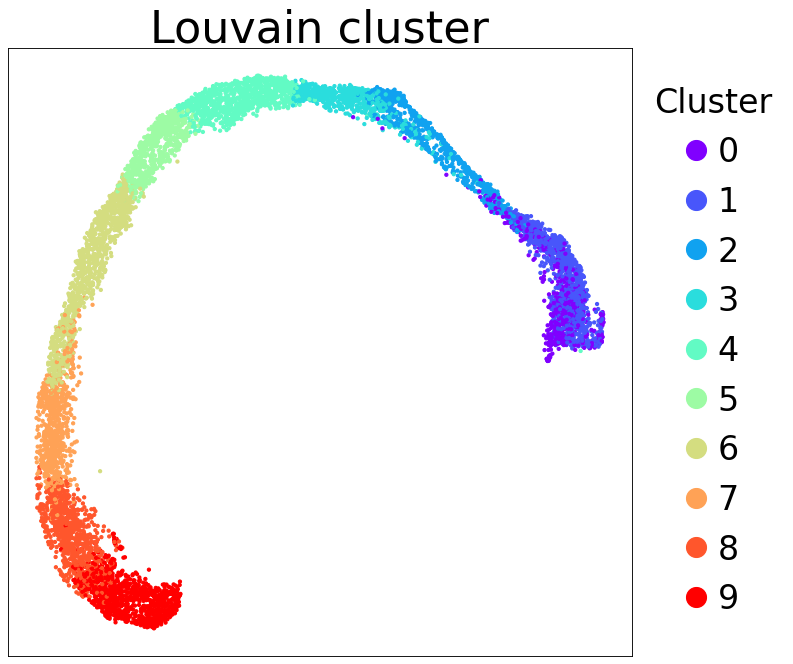

In [21]:
colours_lou = "rainbow"
f = plt.figure(figsize=(10,10))
ax0 = f.add_subplot(1,1,1)
scatter = ax0.scatter(embedding[:, 0], embedding[:, 1], s=size, c=meta["louvain_new"].values.astype(int), cmap=colours_lou, label=meta["louvain_new"].values)
ax0.set_title("Louvain cluster", fontsize=40)
ax0.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
l1 = f.legend(handles=scatter.legend_elements(num=len(sorted(set(meta["louvain_new"].values.astype(int))))-1)[0], 
              labels=sorted(set(meta["louvain_new"].values.astype(int))), loc="upper left", 
              bbox_to_anchor=(0.95, 0.9), markerscale=3., title_fontsize=30, fontsize=30, frameon=False, ncol=1, title="Cluster")
plt.show()

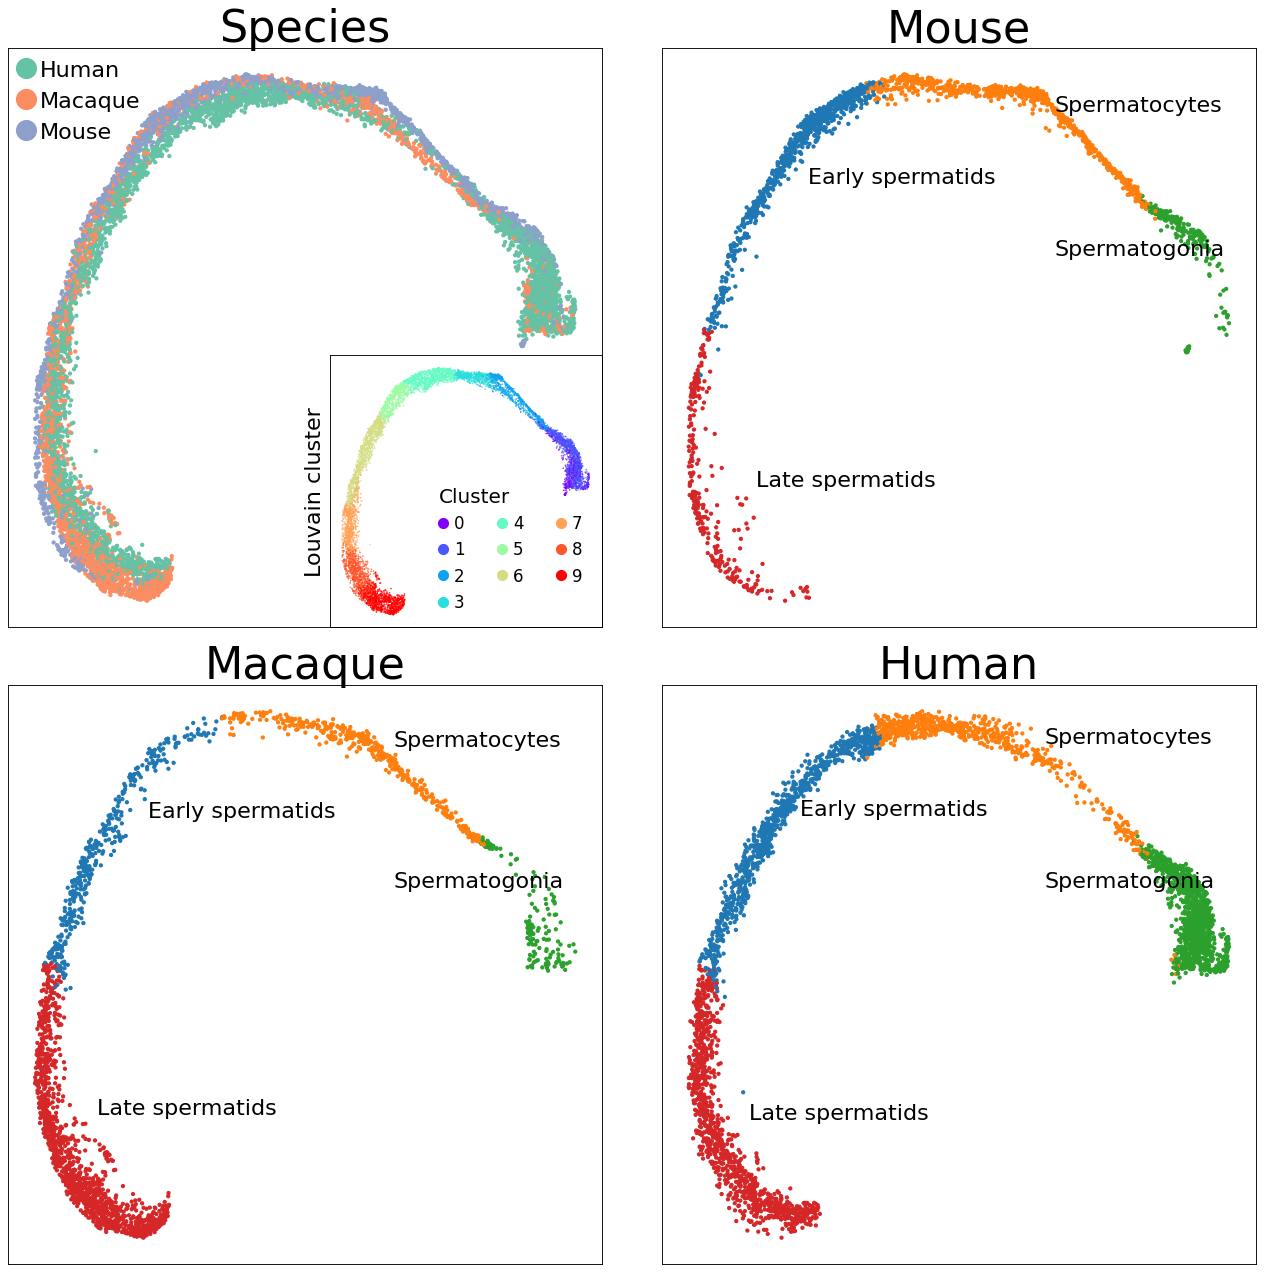

In [22]:
f = plt.figure(figsize=(20,20))

ax0 = f.add_subplot(2,2,1)
order = np.arange(len(embedding))
np.random.shuffle(order)
scatter0 = ax0.scatter(embedding[order, 0], embedding[order, 1], s=size, c=label[order], cmap=colours, label=meta["method"].values[order])
ax0.set_title("Species", fontsize=40)
ax0.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
l1 = f.legend(handles=scatter0.legend_elements(num=len(sorted(set(meta["method"].values))))[0], 
              labels=["Human", "Macaque", "Mouse"], #sorted(set(meta["method"].values)), 
              loc="upper left", 
              bbox_to_anchor=(0.175, 0.915), markerscale=3., title_fontsize=20, fontsize=20, frameon=False, ncol=1)

ax1 = f.add_subplot(2,2,2)
scatter = ax1.scatter(embedding_mouse[:, 0], embedding_mouse[:, 1], s=size, c=label_celltype_mouse, cmap=colours4, label=label_celltype_mouse)
ax1.set_title("Mouse", fontsize=40)
ax1.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax1.annotate("Late spermatids", rotation=0, fontsize=20, xy=(-3, -4))
ax1.annotate("Early spermatids", rotation=0, fontsize=20, xy=(-0.5, 6.5))
ax1.annotate("Spermatocytes", rotation=0, fontsize=20, xy=(11.5, 9.0))
ax1.annotate("Spermatogonia", rotation=0, fontsize=20, xy=(11.5, 4.0))

ax2 = f.add_subplot(2,2,3)
scatter = ax2.scatter(embedding_macaque[:, 0], embedding_macaque[:, 1], s=size, c=label_celltype_macaque, cmap=colours4, label=label_celltype_macaque)
ax2.set_title("Macaque", fontsize=40)
ax2.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax2.annotate("Late spermatids", rotation=0, fontsize=20, xy=(-3, -4))
ax2.annotate("Early spermatids", rotation=0, fontsize=20, xy=(-0.5, 6.5))
ax2.annotate("Spermatocytes", rotation=0, fontsize=20, xy=(11.5, 9.0))
ax2.annotate("Spermatogonia", rotation=0, fontsize=20, xy=(11.5, 4.0))

ax3 = f.add_subplot(2,2,4)
scatter = ax3.scatter(embedding_human[:, 0], embedding_human[:, 1], s=size, c=label_celltype_human, cmap=colours4, label=label_celltype_human)
ax3.set_title("Human", fontsize=40)
ax3.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax3.annotate("Late spermatids", rotation=0, fontsize=20, xy=(-3, -4))
ax3.annotate("Early spermatids", rotation=0, fontsize=20, xy=(-0.5, 6.5))
ax3.annotate("Spermatocytes", rotation=0, fontsize=20, xy=(11.5, 9.0))
ax3.annotate("Spermatogonia", rotation=0, fontsize=20, xy=(11.5, 4.0))

ax0 = f.add_axes([0.381,0.548,0.17,0.17])
scatter = ax0.scatter(embedding[order, 0], embedding[order, 1], s=size / 50, c=meta["louvain_new"].values.astype(int)[order], cmap=colours_lou, label=meta["louvain_new"].values)
ax0.set_ylabel("Louvain cluster", fontsize=20)
ax0.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
l1 = f.legend(handles=scatter.legend_elements(num=len(sorted(set(meta["louvain_new"].values.astype(int))))-1)[0], 
              labels=sorted(set(meta["louvain_new"].values.astype(int))), loc="upper left", 
              bbox_to_anchor=(0.44, 0.645), markerscale=1.5, title_fontsize=18, fontsize=15, frameon=False, ncol=3, title="Cluster")
l1._legend_box.align = "left"

f.subplots_adjust(hspace=.1, wspace=.1)
f.savefig("Umaps_sperm_with_louvain.png", bbox_inches='tight', dpi=100)

In [23]:
meta_human["louvain"] = meta.loc[meta_human.index]["louvain_new"].values
meta_human["cell_type_transfered"] = label_human_new
meta_macaque["louvain"] = meta.loc[meta_macaque.index]["louvain_new"].values
meta_mouse["louvain"] = meta.loc[meta_mouse.index]["louvain_new"].values
meta_macaque["cell_type_transfered"] = label_macaque_new

Trying to set attribute `.obs` of view, copying.
normalizing counts per cell
    finished (0:00:00)


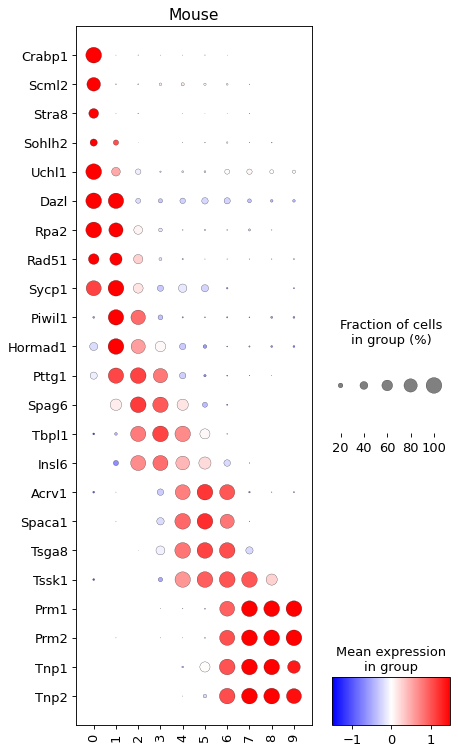

In [24]:
adata_mouse = anndata.read_h5ad(os.path.join("./data_spermatogenesis", "adata_mouse_raw.h5ad"))
adata_mouse = adata_mouse[meta_mouse.index]
adata_mouse.obs["louvain"] = meta_mouse["louvain"].values

sc.pp.normalize_total(adata_mouse, target_sum=1e4)
sc.pp.log1p(adata_mouse)
sc.pp.scale(adata_mouse, max_value=10)
# adata_mouse.raw = adata_mouse

markers = ["Crabp1","Scml2","Stra8","Sohlh2","Uchl1","Dazl","Rpa2","Rad51","Sycp1",#SPG
            "Piwil1","Hormad1","Pttg1","Spag6","Tbpl1","Insl6", #Scytes
            "Acrv1","Spaca1","Tsga8","Tssk1", #STids
            "Prm1","Prm2","Tnp1","Tnp2"]
dp = sc.pl.dotplot(adata_mouse, 
                   markers, groupby='louvain', 
                   dendrogram=False, figsize=(6,len(markers)/2),
                   title="Mouse",
                   swap_axes=True,
                   cmap="bwr", vmin=-1.5, vmax=1.5, return_fig=True)
dp.legend(width=2).show()
plt.show()

Trying to set attribute `.obs` of view, copying.
normalizing counts per cell
    finished (0:00:00)


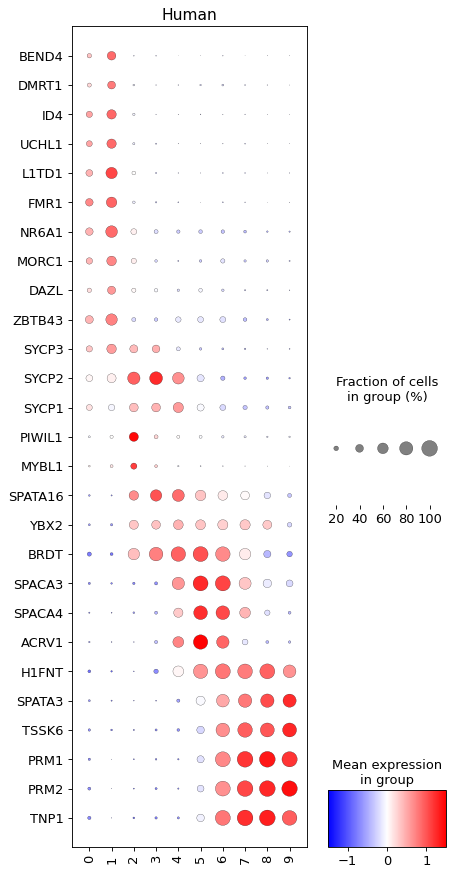

In [25]:
adata_human = anndata.read_h5ad(os.path.join("./data_spermatogenesis", "adata_human_raw.h5ad"))
adata_human = adata_human[meta_human.index]
adata_human.obs["louvain"] = meta_human["louvain"].values

sc.pp.normalize_total(adata_human, target_sum=1e4)
sc.pp.log1p(adata_human)
sc.pp.scale(adata_human, max_value=10)
# adata_human.raw = adata_human

markers = ["BEND4","DMRT1","ID4","UCHL1","L1TD1","FMR1","NR6A1","MORC1","DAZL","ZBTB43","SYCP3",
           "SYCP2","SYCP1","PIWIL1","MYBL1","SPATA16","YBX2",
           "BRDT","SPACA3","SPACA4","ACRV1","H1FNT",
           "SPATA3","TSSK6","PRM1","PRM2","TNP1"]
dp = sc.pl.dotplot(adata_human, 
                   markers, groupby='louvain', 
                   dendrogram=False, figsize=(6,len(markers)/2),
                   title="Human",
                   swap_axes=True,
                   cmap="bwr", vmin=-1.5, vmax=1.5, return_fig=True)
dp.legend(width=2).show()
plt.show()

Trying to set attribute `.obs` of view, copying.
normalizing counts per cell
    finished (0:00:00)


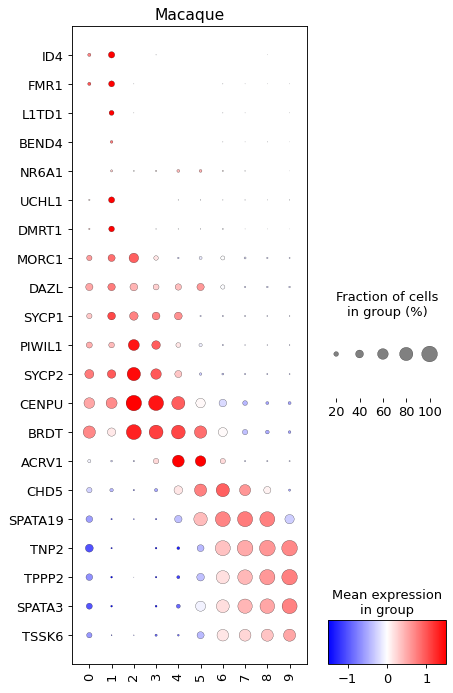

In [26]:
adata_macaque = anndata.read_h5ad(os.path.join("./data_spermatogenesis", "adata_macaque_raw.h5ad"))
adata_macaque = adata_macaque[meta_macaque.index]
adata_macaque.obs["louvain"] = meta_macaque["louvain"].values

sc.pp.normalize_total(adata_macaque, target_sum=1e4)
sc.pp.log1p(adata_macaque)
sc.pp.scale(adata_macaque, max_value=10)
# adata_macaque.raw = adata_macaque

markers = ["ID4","FMR1","L1TD1","BEND4","NR6A1","UCHL1","DMRT1","MORC1","DAZL",
           "SYCP1","PIWIL1","SYCP2","CENPU",
           "BRDT","ACRV1","CHD5","SPATA19",
           "TNP2","TPPP2","SPATA3","TSSK6"]
dp = sc.pl.dotplot(adata_macaque, 
                   markers, groupby='louvain', 
                   dendrogram=False, figsize=(6,len(markers)/2),
                   title="Macaque",
                   swap_axes=True,
                   cmap="bwr", vmin=-1.5, vmax=1.5, return_fig=True)
dp.legend(width=2).show()
plt.show()

# Heatmap

In [27]:
adata_mouse = sc.read_h5ad(os.path.join(data_path, "adata_mouse.h5ad"))
adata_mouse = adata_mouse[meta_mouse.index, :]
adata_mouse = anndata.AnnData(X=adata_mouse.X, obs=meta_mouse, var=adata_mouse.var).copy()

sc.pp.normalize_total(adata_mouse, target_sum=1e4)
sc.pp.log1p(adata_mouse)
adata_mouse.raw = adata_mouse

adata_human = sc.read_h5ad(os.path.join(data_path, "adata_human.h5ad"))
adata_human = adata_human[meta_human.index, :]
adata_human = anndata.AnnData(X=adata_human.X, obs=meta_human, var=adata_human.var).copy()

sc.pp.normalize_total(adata_human, target_sum=1e4)
sc.pp.log1p(adata_human)
adata_human.raw = adata_human

adata_macaque = sc.read_h5ad(os.path.join(data_path, "adata_macaque.h5ad"))
adata_macaque = adata_macaque[meta_macaque.index, :]
adata_macaque = anndata.AnnData(X=adata_macaque.X, obs=meta_macaque, var=adata_macaque.var).copy()

sc.pp.normalize_total(adata_macaque, target_sum=1e4)
sc.pp.log1p(adata_macaque)
adata_macaque.raw = adata_macaque

sc.pp.scale(adata_mouse, max_value=10)
sc.pp.scale(adata_human, max_value=10)
sc.pp.scale(adata_macaque, max_value=10)

adata_human.obs["louvain_v2"] = adata_human.obs["louvain"].values.astype(str)
adata_macaque.obs["louvain_v2"] = adata_macaque.obs["louvain"].values.astype(str)
adata_mouse.obs["louvain_v2"] = adata_mouse.obs["louvain"].values.astype(str)

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


In [28]:
adata_human.obs["louvain_v2"] = adata_human.obs["louvain"].values.astype(str)
adata_macaque.obs["louvain_v2"] = adata_macaque.obs["louvain"].values.astype(str)
adata_mouse.obs["louvain_v2"] = adata_mouse.obs["louvain"].values.astype(str)

In [29]:
sc.tl.rank_genes_groups(adata_human, groupby="louvain_v2", method="t-test", key_added="ttest")

result = adata_human.uns['ttest']
groups = result['names'].dtype.names
df_genes_human = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(200)

sc.tl.rank_genes_groups(adata_mouse, groupby="louvain_v2", method="t-test", key_added="ttest")

result = adata_mouse.uns['ttest']
groups = result['names'].dtype.names
df_genes_mouse = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(200)

sc.tl.rank_genes_groups(adata_macaque, groupby="louvain_v2", method="t-test", key_added="ttest")

result = adata_macaque.uns['ttest']
groups = result['names'].dtype.names
df_genes_macaque = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(200)

ranking genes
... storing 'human_cell_type' as categorical
... storing 'human_cell_type_ref' as categorical
... storing 'method' as categorical
... storing 'louvain_v2' as categorical
... storing 'transfered_label' as categorical
... storing 'cell_type_transfered' as categorical
    finished: added to `.uns['ttest']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
ranking genes
... storing 'method' as categorical
... storing 'mouse_cell_type' as categorical
... storing 'louvain_v2' as categorical
    finished: added to `.uns['ttest']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
 

## Shared markers

In [30]:
from pylab import *
cmap = cm.get_cmap("rainbow", 10)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

In [31]:
markers_0 = set(df_genes_macaque["0_n"]) & set(df_genes_human["0_n"]) & set(df_genes_mouse["0_n"])
markers_1 = set(df_genes_macaque["1_n"]) & set(df_genes_human["1_n"]) & set(df_genes_mouse["1_n"])
markers_2 = set(df_genes_macaque["2_n"]) & set(df_genes_human["2_n"]) & set(df_genes_mouse["2_n"])
markers_3 = set(df_genes_macaque["3_n"]) & set(df_genes_human["3_n"]) & set(df_genes_mouse["3_n"])
markers_4 = set(df_genes_macaque["4_n"]) & set(df_genes_human["4_n"]) & set(df_genes_mouse["4_n"])
markers_5 = set(df_genes_macaque["5_n"]) & set(df_genes_human["5_n"]) & set(df_genes_mouse["5_n"])
markers_6 = set(df_genes_macaque["6_n"]) & set(df_genes_human["6_n"]) & set(df_genes_mouse["6_n"])
markers_7 = set(df_genes_macaque["7_n"]) & set(df_genes_human["7_n"]) & set(df_genes_mouse["7_n"])
markers_8 = set(df_genes_macaque["8_n"]) & set(df_genes_human["8_n"]) & set(df_genes_mouse["8_n"])
markers_9 = set(df_genes_macaque["9_n"]) & set(df_genes_human["9_n"]) & set(df_genes_mouse["9_n"])


num = []
markers = sorted(list(markers_0))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_1.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_2.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_3.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_4.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_5.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_6.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_7.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_8.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_9.difference(set(markers))))
num.append(len(markers))

In [32]:
len(markers)

228

In [33]:
cellid = list(adata_mouse.obs.index[adata_mouse.obs['louvain_v2'].values.astype(str) == "0"])
num_mouse = [len(cellid)]
X_mouse_new = adata_mouse[cellid, markers].X.copy()
X_mouse_new = np.mean(X_mouse_new, axis=0).reshape((1,-1))
for cl in ["1","2","3","4","5","6","7","8","9"]:
    cellid = list(adata_mouse.obs.index[adata_mouse.obs['louvain_v2'].values.astype(str) == cl])
    tmp = adata_mouse[cellid, markers].X.copy()
    tmp = np.mean(tmp, axis=0).reshape((1,-1))
    X_mouse_new = np.concatenate((X_mouse_new, tmp)).copy()
    num_mouse.append(len(cellid))

X_mouse_new = X_mouse_new.T
X_mouse_new[X_mouse_new > 3.0] = 3.0
X_mouse_new[X_mouse_new < -3.0] = -3.0

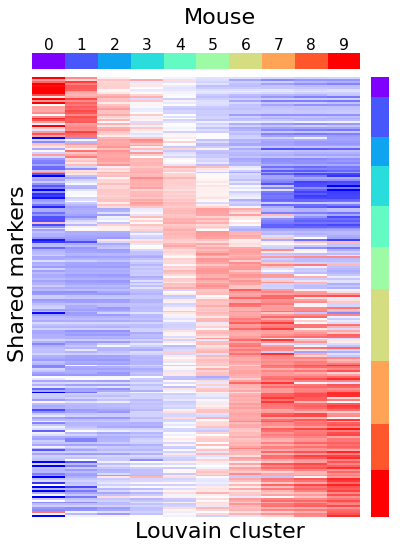

In [34]:
f = plt.figure(figsize=(6,8))
ax = f.add_subplot(111)
im = ax.imshow(X_mouse_new, cmap='bwr', interpolation='nearest', aspect='auto')
ax.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

for i in range(10):
    ax.barh(-9, (np.array(range(10))+1)[::-1][i], height=8, left=-0.5, color=colors[::-1][i])
    ax.annotate(str(i), xy=(i-0.15,-15))

for i in range(len(num)):
    ax.bar(10.1, (np.array(num))[::-1][i], width=0.55, bottom=-0.5, color=colors[::-1][i])

plt.xlabel("Louvain cluster", fontsize=20)
plt.ylabel("Shared markers", fontsize=20)
plt.title("Mouse", fontsize=20)
plt.savefig("sperm-sharedmarkers-mouse.png", dpi=200, bbox_inches='tight')

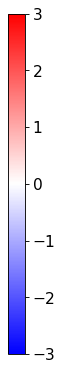

In [35]:
fig,ax = plt.subplots(figsize=(6,8))
plt.colorbar(im, ax=ax, shrink=0.7)
ax.remove()
plt.savefig("sperm-sharedmarkers-mouse-2.png", dpi=200, bbox_inches='tight')

In [36]:
cellid = list(adata_human.obs.index[adata_human.obs['louvain_v2'].values.astype(str) == "0"])
num_human = [len(cellid)]
X_human_new = adata_human[cellid, markers].X.copy()
X_human_new = np.mean(X_human_new, axis=0).reshape((1,-1))
for cl in ["1","2","3","4","5","6","7","8","9"]:
    cellid = list(adata_human.obs.index[adata_human.obs['louvain_v2'].values.astype(str) == cl])
    tmp = adata_human[cellid, markers].X.copy()
    tmp = np.mean(tmp, axis=0).reshape((1,-1))
    X_human_new = np.concatenate((X_human_new, tmp)).copy()
    num_human.append(len(cellid))

X_human_new = X_human_new.T
X_human_new[X_human_new > 1.4] = 1.4
X_human_new[X_human_new < -1.4] = -1.4

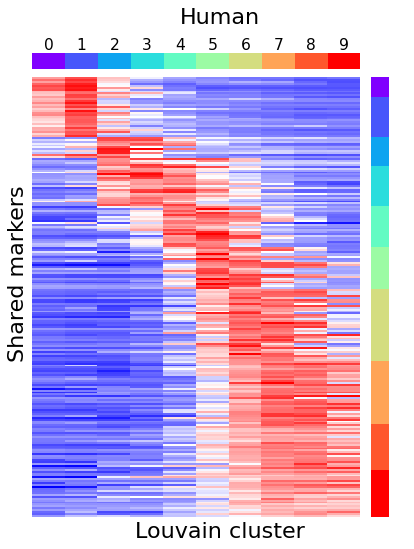

In [37]:
f = plt.figure(figsize=(6,8))
ax = f.add_subplot(111)
im = ax.imshow(X_human_new, cmap='bwr', interpolation='nearest', aspect='auto')
# plt.colorbar(im, shrink=0.7)
ax.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

for i in range(10):
    ax.barh(-9, (np.array(range(10))+1)[::-1][i], height=8, left=-0.5, color=colors[::-1][i])
    ax.annotate(str(i), xy=(i-0.15,-15))

for i in range(len(num)):
    ax.bar(10.1, (np.array(num))[::-1][i], width=0.55, bottom=-0.5, color=colors[::-1][i])
#     ax.annotate(str(i), xy=(i-0.15,-16))

plt.xlabel("Louvain cluster", fontsize=20)
plt.ylabel("Shared markers", fontsize=20)
plt.title("Human", fontsize=20)
plt.savefig("sperm-sharedmarkers-human.png", dpi=200, bbox_inches='tight')

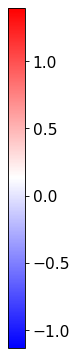

In [38]:
fig,ax = plt.subplots(figsize=(6,8))
plt.colorbar(im, ax=ax, shrink=0.7)
ax.remove()
plt.savefig("sperm-sharedmarkers-human-2.png", dpi=200, bbox_inches='tight')

In [39]:
cellid = list(adata_macaque.obs.index[adata_macaque.obs['louvain_v2'].values.astype(str) == "0"])
num_macaque = [len(cellid)]
X_macaque_new = adata_macaque[cellid, markers].X.copy()
X_macaque_new = np.mean(X_macaque_new, axis=0).reshape((1,-1))
for cl in ["1","2","3","4","5","6","7","8","9"]:
    cellid = list(adata_macaque.obs.index[adata_macaque.obs['louvain_v2'].values.astype(str) == cl])
    tmp = adata_macaque[cellid, markers].X.copy()
    tmp = np.mean(tmp, axis=0).reshape((1,-1))
    X_macaque_new = np.concatenate((X_macaque_new, tmp)).copy()
    num_macaque.append(len(cellid))

X_macaque_new = X_macaque_new.T
X_macaque_new[X_macaque_new > 2.0] = 2.0
X_macaque_new[X_macaque_new < -2.0] = -2.0

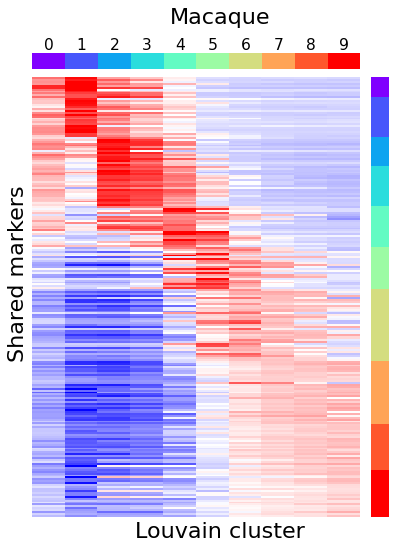

In [40]:
f = plt.figure(figsize=(6,8))
ax = f.add_subplot(111)
im = ax.imshow(X_macaque_new, cmap='bwr', interpolation='nearest', aspect='auto')
# plt.colorbar(im, shrink=0.7)
ax.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

for i in range(10):
    ax.barh(-9, (np.array(range(10))+1)[::-1][i], height=8, left=-0.5, color=colors[::-1][i])
    ax.annotate(str(i), xy=(i-0.15,-15))

for i in range(len(num)):
    ax.bar(10.1, (np.array(num))[::-1][i], width=0.55, bottom=-0.5, color=colors[::-1][i])
#     ax.annotate(str(i), xy=(i-0.15,-16))

plt.xlabel("Louvain cluster", fontsize=20)
plt.ylabel("Shared markers", fontsize=20)
plt.title("Macaque", fontsize=20)
plt.savefig("sperm-sharedmarkers-macaque.png", dpi=200, bbox_inches='tight')

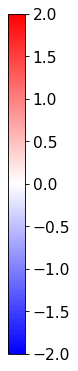

In [41]:
fig,ax = plt.subplots(figsize=(6,8))
plt.colorbar(im, ax=ax, shrink=0.7)
ax.remove()
plt.savefig("sperm-sharedmarkers-macaque-2.png", dpi=200, bbox_inches='tight')

## Human markers

In [42]:
sc.tl.rank_genes_groups(adata_human, groupby="louvain_v2", method="t-test", key_added="ttest")

result = adata_human.uns['ttest']
groups = result['names'].dtype.names
df_genes_human = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(50)


sc.tl.rank_genes_groups(adata_mouse, groupby="louvain_v2", method="t-test", key_added="ttest")

result = adata_mouse.uns['ttest']
groups = result['names'].dtype.names
df_genes_mouse = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(50)


sc.tl.rank_genes_groups(adata_macaque, groupby="louvain_v2", method="t-test", key_added="ttest")

result = adata_macaque.uns['ttest']
groups = result['names'].dtype.names
df_genes_macaque = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(50)

ranking genes
    finished: added to `.uns['ttest']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
ranking genes
    finished: added to `.uns['ttest']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes
    finished: added to `.uns['ttest']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sor

In [43]:
markers_0 = set(df_genes_human["0_n"]) 
markers_1 = set(df_genes_human["1_n"])
markers_2 = set(df_genes_human["2_n"])
markers_3 = set(df_genes_human["3_n"]) 
markers_4 = set(df_genes_human["4_n"]) 
markers_5 = set(df_genes_human["5_n"])
markers_6 = set(df_genes_human["6_n"]) 
markers_7 = set(df_genes_human["7_n"]) 
markers_8 = set(df_genes_human["8_n"]) 
markers_9 = set(df_genes_human["9_n"])


num = []
markers = sorted(list(markers_0))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_1.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_2.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_3.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_4.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_5.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_6.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_7.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_8.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_9.difference(set(markers))))  
num.append(len(markers))

sumnum = num[-1]

In [44]:
cellid = list(adata_mouse.obs.index[adata_mouse.obs['louvain_v2'].values.astype(str) == "0"])
num_mouse = [len(cellid)]
X_mouse_new = adata_mouse[cellid, markers].X.copy()
X_mouse_new = np.mean(X_mouse_new, axis=0).reshape((1,-1))
for cl in ["1","2","3","4","5","6","7","8","9"]:
    cellid = list(adata_mouse.obs.index[adata_mouse.obs['louvain_v2'].values.astype(str) == cl])
    tmp = adata_mouse[cellid, markers].X.copy()
    tmp = np.mean(tmp, axis=0).reshape((1,-1))
    X_mouse_new = np.concatenate((X_mouse_new, tmp)).copy()
    num_mouse.append(len(cellid))

X_mouse_new = X_mouse_new.T
X_mouse_new[X_mouse_new > 3.0] = 3.0
X_mouse_new[X_mouse_new < -3.0] = -3.0

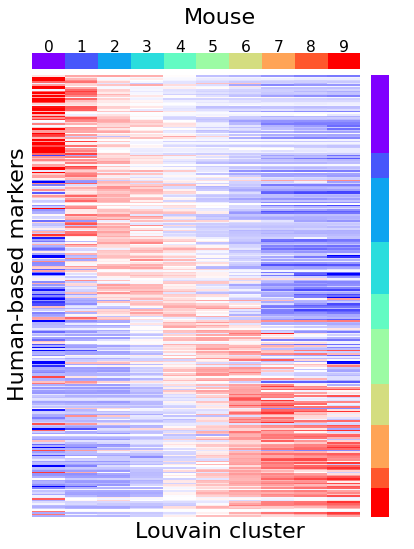

In [45]:
f = plt.figure(figsize=(6,8))
ax = f.add_subplot(111)
im = ax.imshow(X_mouse_new, cmap='bwr', interpolation='nearest', aspect='auto')
# plt.colorbar(im, shrink=0.7)
ax.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

for i in range(10):
    ax.barh(-9.5, (np.array(range(10))+1)[::-1][i], height=10, left=-0.5, color=colors[::-1][i])
    ax.annotate(str(i), xy=(i-0.15,-15.5))

for i in range(len(num)):
    ax.bar(10.1, (np.array(num))[::-1][i], width=0.55, bottom=-0.5, color=colors[::-1][i])
#     ax.annotate(str(i), xy=(i-0.15,-16))

plt.xlabel("Louvain cluster", fontsize=20)
plt.ylabel("Human-based markers", fontsize=20)
plt.title("Mouse", fontsize=20)
plt.savefig("sperm-humanmarkers-mouse.png", dpi=200, bbox_inches='tight')

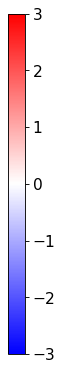

In [46]:
fig,ax = plt.subplots(figsize=(6,8))
plt.colorbar(im, ax=ax, shrink=0.7)
ax.remove()
plt.savefig("sperm-humanmarkers-mouse-2.png", dpi=200, bbox_inches='tight')

In [47]:
cellid = list(adata_human.obs.index[adata_human.obs['louvain_v2'].values.astype(str) == "0"])
num_human = [len(cellid)]
X_human_new = adata_human[cellid, markers].X.copy()
X_human_new = np.mean(X_human_new, axis=0).reshape((1,-1))
for cl in ["1","2","3","4","5","6","7","8","9"]:
    cellid = list(adata_human.obs.index[adata_human.obs['louvain_v2'].values.astype(str) == cl])
    tmp = adata_human[cellid, markers].X.copy()
    tmp = np.mean(tmp, axis=0).reshape((1,-1))
    X_human_new = np.concatenate((X_human_new, tmp)).copy()
    num_human.append(len(cellid))

X_human_new = X_human_new.T
X_human_new[X_human_new > 1.4] = 1.4
X_human_new[X_human_new < -1.4] = -1.4

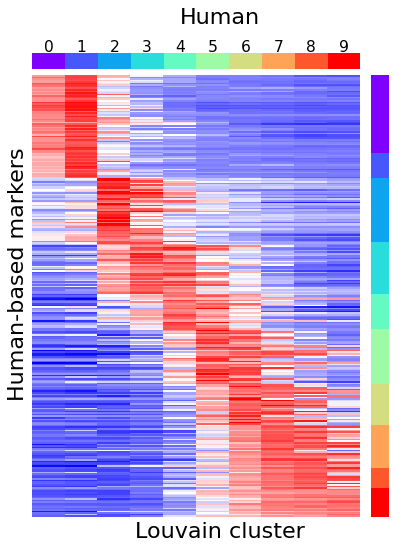

In [48]:
f = plt.figure(figsize=(6,8))
ax = f.add_subplot(111)
im = ax.imshow(X_human_new, cmap='bwr', interpolation='nearest', aspect='auto')
# plt.colorbar(im, shrink=0.7)
ax.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

for i in range(10):
    ax.barh(-9.5, (np.array(range(10))+1)[::-1][i], height=10, left=-0.5, color=colors[::-1][i])
    ax.annotate(str(i), xy=(i-0.15,-15.5))

for i in range(len(num)):
    ax.bar(10.1, (np.array(num))[::-1][i], width=0.55, bottom=-0.5, color=colors[::-1][i])
#     ax.annotate(str(i), xy=(i-0.15,-16))

plt.xlabel("Louvain cluster", fontsize=20)
plt.ylabel("Human-based markers", fontsize=20)
plt.title("Human", fontsize=20)
plt.savefig("sperm-humanmarkers-human.png", dpi=200, bbox_inches='tight')

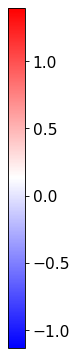

In [49]:
fig,ax = plt.subplots(figsize=(6,8))
plt.colorbar(im, ax=ax, shrink=0.7)
ax.remove()
plt.savefig("sperm-humanmarkers-human-2.png", dpi=200, bbox_inches='tight')

In [50]:
cellid = list(adata_macaque.obs.index[adata_macaque.obs['louvain_v2'].values.astype(str) == "0"])
num_macaque = [len(cellid)]
X_macaque_new = adata_macaque[cellid, markers].X.copy()
X_macaque_new = np.mean(X_macaque_new, axis=0).reshape((1,-1))
for cl in ["1","2","3","4","5","6","7","8","9"]:
    cellid = list(adata_macaque.obs.index[adata_macaque.obs['louvain_v2'].values.astype(str) == cl])
    tmp = adata_macaque[cellid, markers].X.copy()
    tmp = np.mean(tmp, axis=0).reshape((1,-1))
    X_macaque_new = np.concatenate((X_macaque_new, tmp)).copy()
    num_macaque.append(len(cellid))

X_macaque_new = X_macaque_new.T
X_macaque_new[X_macaque_new > 2.0] = 2.0
X_macaque_new[X_macaque_new < -2.0] = -2.0

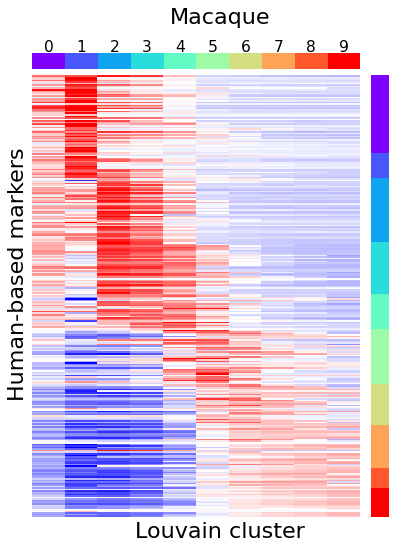

In [51]:
f = plt.figure(figsize=(6,8))
ax = f.add_subplot(111)
im = ax.imshow(X_macaque_new, cmap='bwr', interpolation='nearest', aspect='auto')
# plt.colorbar(im, shrink=0.7)
ax.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

for i in range(10):
    ax.barh(-9.5, (np.array(range(10))+1)[::-1][i], height=10, left=-0.5, color=colors[::-1][i])
    ax.annotate(str(i), xy=(i-0.15,-15.5))

for i in range(len(num)):
    ax.bar(10.1, (np.array(num))[::-1][i], width=0.55, bottom=-0.5, color=colors[::-1][i])
#     ax.annotate(str(i), xy=(i-0.15,-16))

plt.xlabel("Louvain cluster", fontsize=20)
plt.ylabel("Human-based markers", fontsize=20)
plt.title("Macaque", fontsize=20)
plt.savefig("sperm-humanmarkers-macaque.png", dpi=200, bbox_inches='tight')

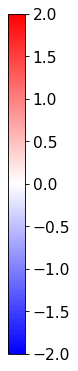

In [52]:
fig,ax = plt.subplots(figsize=(6,8))
plt.colorbar(im, ax=ax, shrink=0.7)
ax.remove()
plt.savefig("sperm-humanmarkers-macaque-2.png", dpi=200, bbox_inches='tight')

## Mouse markers

In [53]:
markers_0 = set(df_genes_mouse["0_n"]) 
markers_1 = set(df_genes_mouse["1_n"])
markers_2 = set(df_genes_mouse["2_n"])
markers_3 = set(df_genes_mouse["3_n"]) 
markers_4 = set(df_genes_mouse["4_n"]) 
markers_5 = set(df_genes_mouse["5_n"])
markers_6 = set(df_genes_mouse["6_n"]) 
markers_7 = set(df_genes_mouse["7_n"]) 
markers_8 = set(df_genes_mouse["8_n"]) 
markers_9 = set(df_genes_mouse["9_n"])


num = []
markers = sorted(list(markers_0))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_1.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_2.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_3.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_4.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_5.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_6.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_7.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_8.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_9.difference(set(markers))))  
num.append(len(markers))

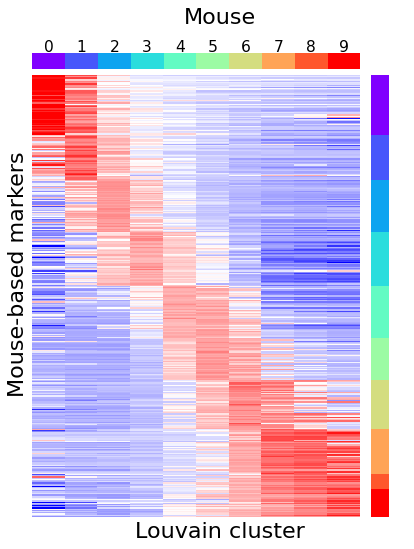

In [54]:
cellid = list(adata_mouse.obs.index[adata_mouse.obs['louvain_v2'].values.astype(str) == "0"])
num_mouse = [len(cellid)]
X_mouse_new = adata_mouse[cellid, markers].X.copy()
X_mouse_new = np.mean(X_mouse_new, axis=0).reshape((1,-1))
for cl in ["1","2","3","4","5","6","7","8","9"]:
    cellid = list(adata_mouse.obs.index[adata_mouse.obs['louvain_v2'].values.astype(str) == cl])
    tmp = adata_mouse[cellid, markers].X.copy()
    tmp = np.mean(tmp, axis=0).reshape((1,-1))
    X_mouse_new = np.concatenate((X_mouse_new, tmp)).copy()
    num_mouse.append(len(cellid))

X_mouse_new = X_mouse_new.T
X_mouse_new[X_mouse_new > 3.0] = 3.0
X_mouse_new[X_mouse_new < -3.0] = -3.0


f = plt.figure(figsize=(6,8))
ax = f.add_subplot(111)
im = ax.imshow(X_mouse_new, cmap='bwr', interpolation='nearest', aspect='auto')
# plt.colorbar(im, shrink=0.7)
ax.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

for i in range(10):
    ax.barh(-9.5/sumnum*num[-1], (np.array(range(10))+1)[::-1][i], height=10/sumnum*num[-1], left=-0.5, color=colors[::-1][i])
    ax.annotate(str(i), xy=(i-0.15,-15.5/sumnum*num[-1]))

for i in range(len(num)):
    ax.bar(10.1, (np.array(num))[::-1][i], width=0.55, bottom=-0.5, color=colors[::-1][i])
#     ax.annotate(str(i), xy=(i-0.15,-16))

plt.xlabel("Louvain cluster", fontsize=20)
plt.ylabel("Mouse-based markers", fontsize=20)
plt.title("Mouse", fontsize=20)
plt.savefig("sperm-mousemarkers-mouse.png", dpi=200, bbox_inches='tight')

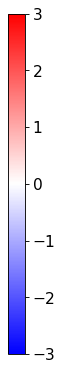

In [55]:
fig,ax = plt.subplots(figsize=(6,8))
plt.colorbar(im, ax=ax, shrink=0.7)
ax.remove()
plt.savefig("sperm-mousemarkers-mouse-2.png", dpi=200, bbox_inches='tight')

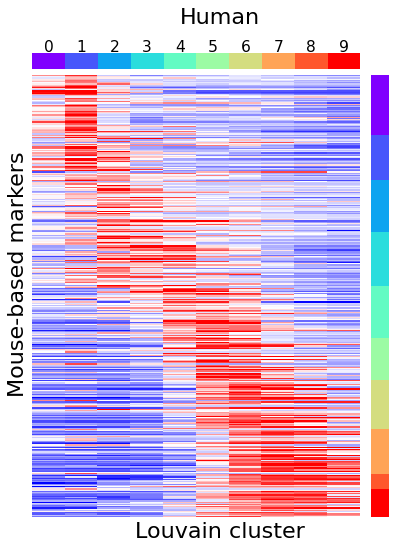

In [56]:
cellid = list(adata_human.obs.index[adata_human.obs['louvain_v2'].values.astype(str) == "0"])
num_human = [len(cellid)]
X_human_new = adata_human[cellid, markers].X.copy()
X_human_new = np.mean(X_human_new, axis=0).reshape((1,-1))
for cl in ["1","2","3","4","5","6","7","8","9"]:
    cellid = list(adata_human.obs.index[adata_human.obs['louvain_v2'].values.astype(str) == cl])
    tmp = adata_human[cellid, markers].X.copy()
    tmp = np.mean(tmp, axis=0).reshape((1,-1))
    X_human_new = np.concatenate((X_human_new, tmp)).copy()
    num_human.append(len(cellid))

X_human_new = X_human_new.T
X_human_new[X_human_new > 1.0] = 1.0
X_human_new[X_human_new < -1.0] = -1.0


f = plt.figure(figsize=(6,8))
ax = f.add_subplot(111)
im = ax.imshow(X_human_new, cmap='bwr', interpolation='nearest', aspect='auto')
# plt.colorbar(im, shrink=0.7)
ax.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

for i in range(10):
    ax.barh(-9.5/sumnum*num[-1], (np.array(range(10))+1)[::-1][i], height=10/sumnum*num[-1], left=-0.5, color=colors[::-1][i])
    ax.annotate(str(i), xy=(i-0.15,-15.5/sumnum*num[-1]))

for i in range(len(num)):
    ax.bar(10.1, (np.array(num))[::-1][i], width=0.55, bottom=-0.5, color=colors[::-1][i])
#     ax.annotate(str(i), xy=(i-0.15,-16))

plt.xlabel("Louvain cluster", fontsize=20)
plt.ylabel("Mouse-based markers", fontsize=20)
plt.title("Human", fontsize=20)
plt.savefig("sperm-mousemarkers-human.png", dpi=200, bbox_inches='tight')

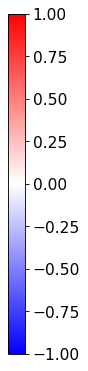

In [57]:
fig,ax = plt.subplots(figsize=(6,8))
plt.colorbar(im, ax=ax, shrink=0.7)
ax.remove()
plt.savefig("sperm-mousemarkers-human-2.png", dpi=200, bbox_inches='tight')

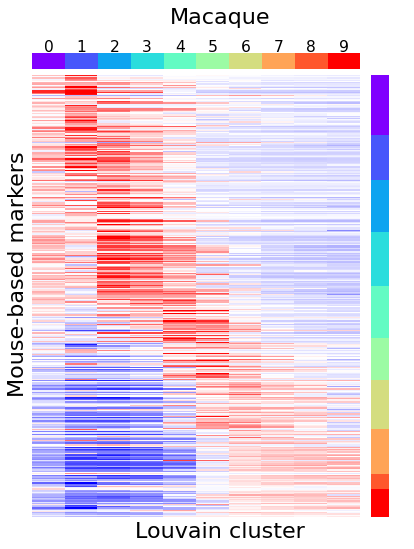

In [58]:
cellid = list(adata_macaque.obs.index[adata_macaque.obs['louvain_v2'].values.astype(str) == "0"])
num_macaque = [len(cellid)]
X_macaque_new = adata_macaque[cellid, markers].X.copy()
X_macaque_new = np.mean(X_macaque_new, axis=0).reshape((1,-1))
for cl in ["1","2","3","4","5","6","7","8","9"]:
    cellid = list(adata_macaque.obs.index[adata_macaque.obs['louvain_v2'].values.astype(str) == cl])
    tmp = adata_macaque[cellid, markers].X.copy()
    tmp = np.mean(tmp, axis=0).reshape((1,-1))
    X_macaque_new = np.concatenate((X_macaque_new, tmp)).copy()
    num_macaque.append(len(cellid))

X_macaque_new = X_macaque_new.T
X_macaque_new[X_macaque_new > 2.0] = 2.0
X_macaque_new[X_macaque_new < -2.0] = -2.0


f = plt.figure(figsize=(6,8))
ax = f.add_subplot(111)
im = ax.imshow(X_macaque_new, cmap='bwr', interpolation='nearest', aspect='auto')
# plt.colorbar(im, shrink=0.7)
ax.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

for i in range(10):
    ax.barh(-9.5/sumnum*num[-1], (np.array(range(10))+1)[::-1][i], height=10/sumnum*num[-1], left=-0.5, color=colors[::-1][i])
    ax.annotate(str(i), xy=(i-0.15,-15.5/sumnum*num[-1]))

for i in range(len(num)):
    ax.bar(10.1, (np.array(num))[::-1][i], width=0.55, bottom=-0.5, color=colors[::-1][i])
#     ax.annotate(str(i), xy=(i-0.15,-16))

plt.xlabel("Louvain cluster", fontsize=20)
plt.ylabel("Mouse-based markers", fontsize=20)
plt.title("Macaque", fontsize=20)
plt.savefig("sperm-mousemarkers-macaque.png", dpi=200, bbox_inches='tight')

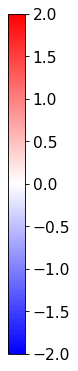

In [59]:
fig,ax = plt.subplots(figsize=(6,8))
plt.colorbar(im, ax=ax, shrink=0.7)
ax.remove()
plt.savefig("sperm-mousemarkers-macaque-2.png", dpi=200, bbox_inches='tight')

## Macaque markers

In [60]:
markers_0 = set(df_genes_macaque["0_n"]) 
markers_1 = set(df_genes_macaque["1_n"])
markers_2 = set(df_genes_macaque["2_n"])
markers_3 = set(df_genes_macaque["3_n"]) 
markers_4 = set(df_genes_macaque["4_n"]) 
markers_5 = set(df_genes_macaque["5_n"])
markers_6 = set(df_genes_macaque["6_n"]) 
markers_7 = set(df_genes_macaque["7_n"]) 
markers_8 = set(df_genes_macaque["8_n"]) 
markers_9 = set(df_genes_macaque["9_n"])


num = []
markers = sorted(list(markers_0))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_1.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_2.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_3.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_4.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_5.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_6.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_7.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_8.difference(set(markers))))
num.append(len(markers))
markers = list(markers) + sorted(list(markers_9.difference(set(markers))))  
num.append(len(markers))

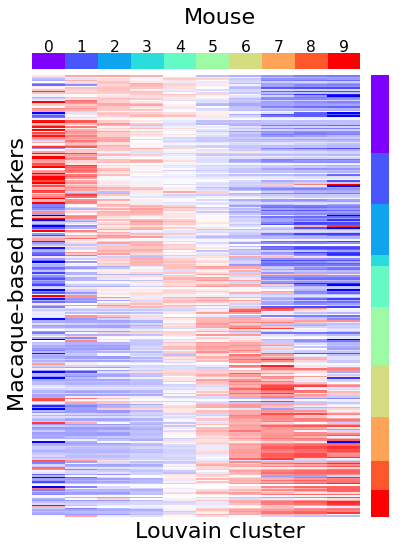

In [61]:
cellid = list(adata_mouse.obs.index[adata_mouse.obs['louvain_v2'].values.astype(str) == "0"])
num_mouse = [len(cellid)]
X_mouse_new = adata_mouse[cellid, markers].X.copy()
X_mouse_new = np.mean(X_mouse_new, axis=0).reshape((1,-1))
for cl in ["1","2","3","4","5","6","7","8","9"]:
    cellid = list(adata_mouse.obs.index[adata_mouse.obs['louvain_v2'].values.astype(str) == cl])
    tmp = adata_mouse[cellid, markers].X.copy()
    tmp = np.mean(tmp, axis=0).reshape((1,-1))
    X_mouse_new = np.concatenate((X_mouse_new, tmp)).copy()
    num_mouse.append(len(cellid))

X_mouse_new = X_mouse_new.T
X_mouse_new[X_mouse_new > 3.0] = 3.0
X_mouse_new[X_mouse_new < -3.0] = -3.0


f = plt.figure(figsize=(6,8))
ax = f.add_subplot(111)
im = ax.imshow(X_mouse_new, cmap='bwr', interpolation='nearest', aspect='auto')
# plt.colorbar(im, shrink=0.7)
ax.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

for i in range(10):
    ax.barh(-9.5/sumnum*num[-1], (np.array(range(10))+1)[::-1][i], height=10/sumnum*num[-1], left=-0.5, color=colors[::-1][i])
    ax.annotate(str(i), xy=(i-0.15,-15.5/sumnum*num[-1]))

for i in range(len(num)):
    ax.bar(10.1, (np.array(num))[::-1][i], width=0.55, bottom=-0.5, color=colors[::-1][i])
#     ax.annotate(str(i), xy=(i-0.15,-16))

plt.xlabel("Louvain cluster", fontsize=20)
plt.ylabel("Macaque-based markers", fontsize=20)
plt.title("Mouse", fontsize=20)
plt.savefig("sperm-macaquemarkers-mouse.png", dpi=200, bbox_inches='tight')

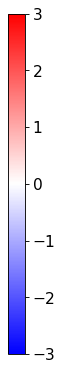

In [62]:
fig,ax = plt.subplots(figsize=(6,8))
plt.colorbar(im, ax=ax, shrink=0.7)
ax.remove()
plt.savefig("sperm-macaquemarkers-mouse-2.png", dpi=200, bbox_inches='tight')

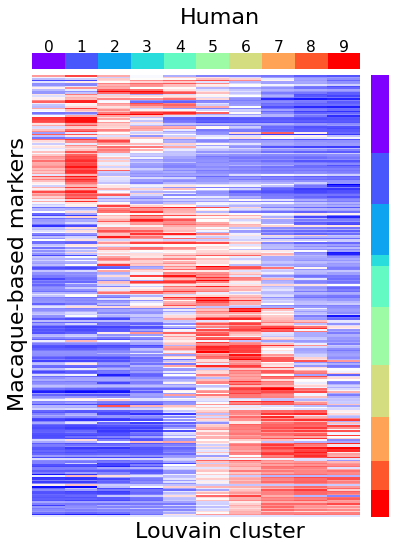

In [63]:
cellid = list(adata_human.obs.index[adata_human.obs['louvain_v2'].values.astype(str) == "0"])
num_human = [len(cellid)]
X_human_new = adata_human[cellid, markers].X.copy()
X_human_new = np.mean(X_human_new, axis=0).reshape((1,-1))
for cl in ["1","2","3","4","5","6","7","8","9"]:
    cellid = list(adata_human.obs.index[adata_human.obs['louvain_v2'].values.astype(str) == cl])
    tmp = adata_human[cellid, markers].X.copy()
    tmp = np.mean(tmp, axis=0).reshape((1,-1))
    X_human_new = np.concatenate((X_human_new, tmp)).copy()
    num_human.append(len(cellid))

X_human_new = X_human_new.T
X_human_new[X_human_new > 1.4] = 1.4
X_human_new[X_human_new < -1.4] = -1.4


f = plt.figure(figsize=(6,8))
ax = f.add_subplot(111)
im = ax.imshow(X_human_new, cmap='bwr', interpolation='nearest', aspect='auto')
# plt.colorbar(im, shrink=0.7)
ax.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

for i in range(10):
    ax.barh(-9.5/sumnum*num[-1], (np.array(range(10))+1)[::-1][i], height=10/sumnum*num[-1], left=-0.5, color=colors[::-1][i])
    ax.annotate(str(i), xy=(i-0.15,-15.5/sumnum*num[-1]))

for i in range(len(num)):
    ax.bar(10.1, (np.array(num))[::-1][i], width=0.55, bottom=-0.5, color=colors[::-1][i])
#     ax.annotate(str(i), xy=(i-0.15,-16))

plt.xlabel("Louvain cluster", fontsize=20)
plt.ylabel("Macaque-based markers", fontsize=20)
plt.title("Human", fontsize=20)
plt.savefig("sperm-macaquemarkers-human.png", dpi=200, bbox_inches='tight')

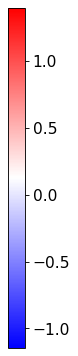

In [64]:
fig,ax = plt.subplots(figsize=(6,8))
plt.colorbar(im, ax=ax, shrink=0.7)
ax.remove()
plt.savefig("sperm-macaquemarkers-human-2.png", dpi=200, bbox_inches='tight')

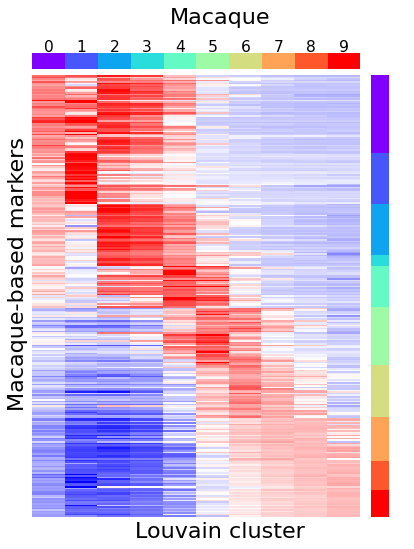

In [65]:
cellid = list(adata_macaque.obs.index[adata_macaque.obs['louvain_v2'].values.astype(str) == "0"])
num_macaque = [len(cellid)]
X_macaque_new = adata_macaque[cellid, markers].X.copy()
X_macaque_new = np.mean(X_macaque_new, axis=0).reshape((1,-1))
for cl in ["1","2","3","4","5","6","7","8","9"]:
    cellid = list(adata_macaque.obs.index[adata_macaque.obs['louvain_v2'].values.astype(str) == cl])
    tmp = adata_macaque[cellid, markers].X.copy()
    tmp = np.mean(tmp, axis=0).reshape((1,-1))
    X_macaque_new = np.concatenate((X_macaque_new, tmp)).copy()
    num_macaque.append(len(cellid))

X_macaque_new = X_macaque_new.T
X_macaque_new[X_macaque_new > 2.0] = 2.0
X_macaque_new[X_macaque_new < -2.0] = -2.0


f = plt.figure(figsize=(6,8))
ax = f.add_subplot(111)
im = ax.imshow(X_macaque_new, cmap='bwr', interpolation='nearest', aspect='auto')
# plt.colorbar(im, shrink=0.7)
ax.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

for i in range(10):
    ax.barh(-9.5/sumnum*num[-1], (np.array(range(10))+1)[::-1][i], height=10/sumnum*num[-1], left=-0.5, color=colors[::-1][i])
    ax.annotate(str(i), xy=(i-0.15,-15.5/sumnum*num[-1]))

for i in range(len(num)):
    ax.bar(10.1, (np.array(num))[::-1][i], width=0.55, bottom=-0.5, color=colors[::-1][i])
#     ax.annotate(str(i), xy=(i-0.15,-16))

plt.xlabel("Louvain cluster", fontsize=20)
plt.ylabel("Macaque-based markers", fontsize=20)
plt.title("Macaque", fontsize=20)
plt.savefig("sperm-macaquemarkers-macaque.png", dpi=200, bbox_inches='tight')

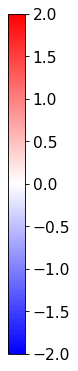

In [66]:
fig,ax = plt.subplots(figsize=(6,8))
plt.colorbar(im, ax=ax, shrink=0.7)
ax.remove()
plt.savefig("sperm-macaquemarkers-macaque-2.png", dpi=200, bbox_inches='tight')